In [1]:
import numpy as np, pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [3]:
import sys
import os
os.environ["OMP_NUM_THREADS"] = "1"   # set before importing numpy/xgboost
os.environ["MKL_NUM_THREADS"] = "1"

classes_path = os.path.abspath(r"D:\Repositories\PhD\src\classes")
src_path = os.path.abspath(r"D:\Repositories\PhD\src\functions")
sys.path.append(src_path)
sys.path.append(classes_path)
print(sys.path)

import cepstrum_fe
import helpers
import AD_Mahalanobis_Cluster as admc

['d:\\Anaconda\\envs\\ml-cpu\\python311.zip', 'd:\\Anaconda\\envs\\ml-cpu\\DLLs', 'd:\\Anaconda\\envs\\ml-cpu\\Lib', 'd:\\Anaconda\\envs\\ml-cpu', '', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages\\win32', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages\\win32\\lib', 'd:\\Anaconda\\envs\\ml-cpu\\Lib\\site-packages\\Pythonwin', 'D:\\Repositories\\PhD\\src\\functions', 'D:\\Repositories\\PhD\\src\\classes', 'D:\\Repositories\\PhD\\src\\functions', 'D:\\Repositories\\PhD\\src\\classes']


In [16]:
def extract_features(X_healthy, X_faulty, 
                     fs,
                     shuffle = True,
                     slice_len_s = 2, # slice length in seconds
                     hop_s = 0.25, #percentage overlap
                     frame_len_s=0.25, # Length of the cepstrum frame in seconds
                     frame_hop_s = 0.125, # overlap in seconds
                     quef_search_ms = (0.2, 2000.0), #quefrequency range of the Cepstrum graph
                     lifter_quef_ms = 5.0, # sum energy below lifter_quef_ms for low-quefrequency metric
                     n_ceps = 24, # Keep first n_ceps coefficients (including c0). A simple low-time filter
                     use_complex = False,
                     return_per_frame = False
                     ):
    
    healthy_df, _ = cepstrum_fe.batch_extract_cepstrum(X_healthy, fs,
                                                              slice_len_s = slice_len_s,
                                                              hop_s = hop_s,
                                                              frame_len_s = frame_len_s,
                                                              frame_hop_s = frame_hop_s,
                                                              quef_search_ms = quef_search_ms,
                                                              lifter_quef_ms = lifter_quef_ms,
                                                              n_ceps=n_ceps,
                                                              use_complex=use_complex,
                                                              return_per_frame=return_per_frame)
    healthy_df['fault'] = 0
    healthy_df['baseline'] = 1

    faulty_df, _ = cepstrum_fe.batch_extract_cepstrum(X_faulty, fs,
                                                        slice_len_s = slice_len_s,
                                                        hop_s = hop_s,
                                                        frame_len_s = frame_len_s,
                                                        frame_hop_s = frame_hop_s,
                                                        quef_search_ms = quef_search_ms,
                                                        lifter_quef_ms = lifter_quef_ms,
                                                        n_ceps=n_ceps,
                                                        use_complex=use_complex,
                                                        return_per_frame=return_per_frame)
    faulty_df['fault'] = 1
    faulty_df['baseline'] = 0

    df_overall = pd.concat((healthy_df,faulty_df))
    df_overall = df_overall.reset_index(drop=True)
    if shuffle:
        df_overall = df_overall.sample(frac = 1) # shuffle df

    return df_overall

In [14]:
def fit_mahalanobis(healthy_signal, faulty_signal, fs, sample_size = 200, random_state = 42):

    df_features = extract_features(healthy_signal, faulty_signal, fs = fs)

    baseline_df = df_features[df_features['baseline'] == 1]
    test_base = baseline_df.sample(sample_size)
    baseline_df = baseline_df.drop(test_base.index)
    
    df_new = pd.concat((df_features[df_features['baseline'] == 0], test_base)).sample(frac=1, random_state = random_state)
    df_new['baseline'] = 0

    # 1) Configure classifier
    cfg = admc.PCAMahalanobisConfig(
        n_components=3,          # or None for variance target
        var_target=0.95,
        standardize=True,
        robust=True,             # MinCovDet for baseline covariance
        q_ok=0.90,
        q_warn=0.99,
        baseline_col="baseline",
        baseline_value=1,
        feature_cols=None,       # infer numeric cols (excl. 'label')
        cluster_mode="threshold",# or "kmeans"
        kmeans_space="scores",
        random_state=random_state
    )

    clf = admc.PCAMahalanobisClassifier(cfg)

    # 2) Fit ONLY on baseline
    clf.fit(baseline_df)

    # (Optional) Inspect thresholds
    print("Thresholds (d^2):", clf.thresholds())

    # 3) Score monitoring data
    res_new = clf.transform(df_new)      # contains PC1..PCk, md2, md
    res_new["State"] = clf.predict(df_new)
    scored_new = df_new.join(res_new[["md2", "md", "State"]])
    state_faults = scored_new.groupby('State').agg({'fault' : ['count','sum']})
    print(scored_new["State"].value_counts())

    overall_res = pd.concat((scored_new, baseline_df), axis = 0)
    overall_res['State'] = overall_res['State'].fillna('Baseline')

    res_base = clf.transform(baseline_df)
    res_base['State'] = 'Baseline'

    results = pd.concat((res_base, res_new))

    return results, state_faults, scored_new

In [7]:
def fit_mahalanobis_ice(healthy_signals, faulty_signals, fs, sample_size = 200, random_state = 42):

    c1_healthy = healthy_signals[0]
    c2_healthy = healthy_signals[1]
    c3_healthy = healthy_signals[2]

    c1_faulty = faulty_signals[0]
    c2_faulty = faulty_signals[1]
    c3_faulty = faulty_signals[2]

    c1_feats = extract_features(c1_healthy, c1_faulty, fs = fs, shuffle = False, slice_len_s = 0.05, hop_s = 0.025, frame_len_s=0.25)
    c1_feats.columns = c1_feats.columns + '_c1'
    c2_feats = extract_features(c2_healthy, c2_faulty, fs = fs, shuffle = False, slice_len_s = 0.05, hop_s = 0.025, frame_len_s=0.25)
    c2_feats.columns = c2_feats.columns + '_c2'
    c3_feats = extract_features(c3_healthy, c3_faulty, fs = fs, shuffle = False, slice_len_s = 0.05, hop_s = 0.025, frame_len_s=0.25)
    c3_feats.columns = c3_feats.columns + '_c3'

    df_features = pd.concat((c1_feats.reset_index(drop=True), c2_feats.reset_index(drop=True), c3_feats.reset_index(drop=True)), axis = 1)
    df_features['baseline'] = (df_features['baseline_c1'] & df_features['baseline_c2'] & df_features['baseline_c3'])
    df_features['fault'] = (df_features['fault_c1'] & df_features['fault_c2'] & df_features['fault_c3'])
    print(df_features.shape)

    baseline_df = df_features[df_features['baseline'] == 1]
    test_base = baseline_df.sample(sample_size)
    baseline_df = baseline_df.drop(test_base.index)
    
    df_new = pd.concat((df_features[df_features['baseline'] == 0], test_base)).sample(frac=1, random_state = random_state)
    df_new['baseline'] = 0

    # 1) Configure classifier
    cfg = admc.PCAMahalanobisConfig(
        n_components=3,          # or None for variance target
        var_target=0.95,
        standardize=True,
        robust=True,             # MinCovDet for baseline covariance
        q_ok=0.90,
        q_warn=0.99,
        baseline_col="baseline",
        baseline_value=1,
        feature_cols=None,       # infer numeric cols (excl. 'label')
        cluster_mode="threshold",# or "kmeans"
        kmeans_space="scores",
        random_state=random_state
    )

    clf = admc.PCAMahalanobisClassifier(cfg)

    # 2) Fit ONLY on baseline
    clf.fit(baseline_df)

    # (Optional) Inspect thresholds
    print("Thresholds (d^2):", clf.thresholds())

    # 3) Score monitoring data
    res_new = clf.transform(df_new)      # contains PC1..PCk, md2, md
    res_new["State"] = clf.predict(df_new)
    scored_new = df_new.join(res_new[["md2", "md", "State"]])
    state_faults = scored_new.groupby('State').agg({'fault' : ['count','sum']})
    print(scored_new["State"].value_counts())

    overall_res = pd.concat((scored_new, baseline_df), axis = 0)
    overall_res['State'] = overall_res['State'].fillna('Baseline')

    res_base = clf.transform(baseline_df)
    res_base['State'] = 'Baseline'

    results = pd.concat((res_base, res_new))

    return results, state_faults, scored_new

In [8]:
def plot_3d(results):
    # Define color mapping
    state_colors = {
        "Baseline": "green",
        "OK": "green",
        "Warning": "orange",
        "Error": "red"
    }

    translate = {
    "Baseline": "Референтно състояние",
    "OK": "Изправен",
    "Warning": "Предупреждение",
    "Error": "Повреда"
}

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    states = results['State'].unique()
    for state in states:
        g = results[results['State'] == state]
        ax.scatter(
            g['PC1'], g['PC2'], g['PC3'],
            label=translate.get(state, state),
            alpha=0.5,
            s=30,
            color=state_colors.get(state, "gray")  # fallback gray if unknown
        )

    ax.set_xlabel("Главна Ос 1", fontsize = 16)
    ax.set_ylabel("Главна Ос 2", fontsize = 16)
    ax.set_zlabel("Главна Ос 3", fontsize = 16)
    ax.set_title("Групиране чрез разстояние на Махаланобис", fontsize = 16)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [9]:
def calc_scores(TP, TN, FP, FN):

    acc = (TP+TN) / (TP+TN+FP+FN)
    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    f1 = (2*precision*recall) / (precision+recall)

    print("F1: ", f1)
    print("Accuracy: ", acc)
    print("Precision: ", precision)
    print("Recall: ", recall)

# EE

In [11]:
df = pd.read_csv(r"D:\Repositories\PhD\parsed_data\EE_data\1730_case_edu.csv")
df

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
0,0.014603,0.192922,0,3,1730,0,12000,0,0
1,0.054449,0.164364,0,3,1730,0,12000,0,0
2,0.107646,0.090811,0,3,1730,0,12000,0,0
3,0.133722,0.086496,0,3,1730,0,12000,0,0
4,0.112652,0.099235,0,3,1730,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
3528365,0.091857,0.155118,21,3,1730,2,48000,1,1
3528366,0.028101,-0.093087,21,3,1730,2,48000,1,1
3528367,-0.061238,-0.144956,21,3,1730,2,48000,1,1
3528368,0.079918,0.077803,21,3,1730,2,48000,1,1


In [12]:
df_1797 = pd.read_csv(r"D:\Repositories\PhD\parsed_data\EE_data\1797_case_edu.csv")
df_1797

,DE,FE,fault_diameter,horse_power,rounds_per_minute,fault_end,samples_per_second,fault_element,fault
0,0.053197,0.145667,0,0,1797,0,12000,0,0
1,0.088662,0.097796,0,0,1797,0,12000,0,0
2,0.099718,0.054856,0,0,1797,0,12000,0,0
3,0.058621,0.036982,0,0,1797,0,12000,0,0
4,-0.004590,0.054445,0,0,1797,0,12000,0,0
...,...,...,...,...,...,...,...,...,...
3405142,-0.320642,-0.199291,21,0,1797,2,48000,3,1
3405143,0.047982,-0.487955,21,0,1797,2,48000,3,1
3405144,0.306873,-0.015409,21,0,1797,2,48000,3,1
3405145,-0.050902,0.155529,21,0,1797,2,48000,3,1


## 1730 RPM - fault_end = 1; fs = 12000; fault_element = 1;fault_diameter = 7

(485643,)
(366988,)
Thresholds (d^2): (6.251388631170325, 11.344866730144373)
State
Error      118
OK          15
Warning      3
Name: count, dtype: int64


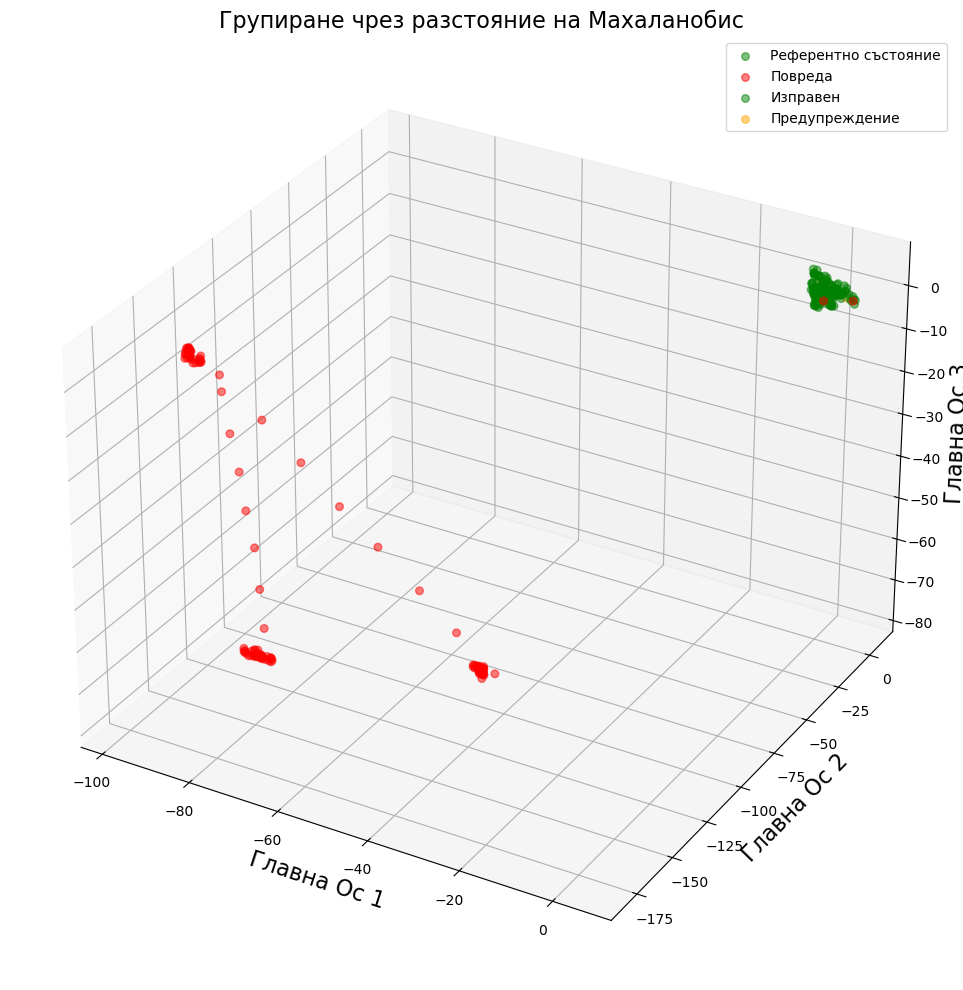

In [18]:
de_healthy = df[(df['fault_end'] == 0) & (df['samples_per_second'] == 12000) & (df['fault_element'] == 0) & (df['fault_diameter'] == 0)]['DE']
de_faulty = df[(df['fault_end'] == 1) & (df['samples_per_second'] == 12000) & (df['fault_element'] == 1) & (df['fault_diameter'] == 7)]['DE']

print(de_healthy.shape)
print(de_faulty.shape)

results, state_faults, scored_new = fit_mahalanobis(de_healthy, de_faulty, fs = 12000, sample_size=20)

plot_3d(results)

In [19]:
state_faults

fault     
        count  sum
State             
Error     118  116
OK         15    0
Warning     3    0

In [20]:
calc_scores(TP = 116, TN = 18, FP = 2, FN = 0)

F1:  0.9914529914529915
Accuracy:  0.9852941176470589
Precision:  0.9830508474576272
Recall:  1.0


## 1730 RPM - fault_end = 1; fs = 12000; fault_element = 1;fault_diameter = 21

(485643,)
(365828,)
Thresholds (d^2): (6.251388631170325, 11.344866730144373)
State
Error      117
OK          17
Warning      1
Name: count, dtype: int64


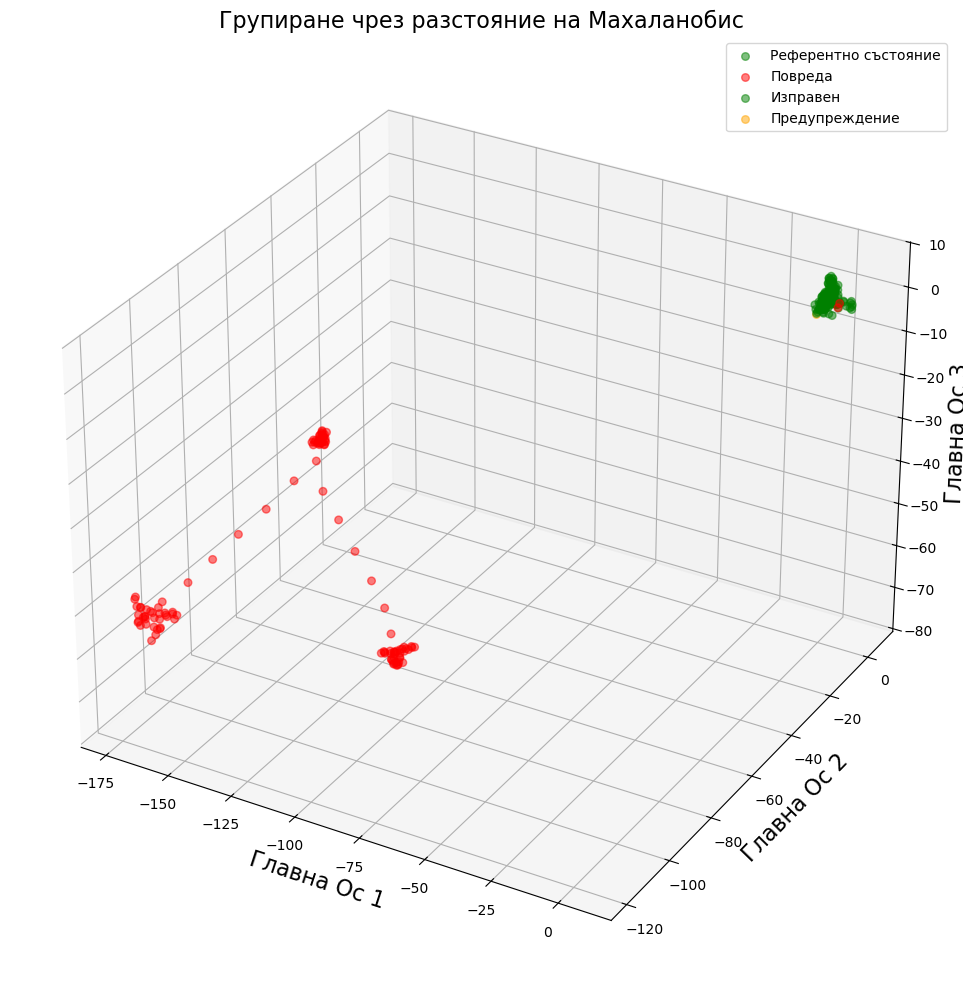

In [21]:
de_healthy = df[(df['fault_end'] == 0) & (df['samples_per_second'] == 12000) & (df['fault_element'] == 0) & (df['fault_diameter'] == 0)]['DE']
de_faulty = df[(df['fault_end'] == 1) & (df['samples_per_second'] == 12000) & (df['fault_element'] == 1) & (df['fault_diameter'] == 21)]['DE']

print(de_healthy.shape)
print(de_faulty.shape)

results, state_faults, scored_new = fit_mahalanobis(de_healthy, de_faulty, fs = 12000, sample_size=20)

plot_3d(results)

In [22]:
state_faults

fault     
        count  sum
State             
Error     117  115
OK         17    0
Warning     1    0

In [23]:
calc_scores(TP=115, TN=18, FP = 2, FN = 0)

F1:  0.9913793103448275
Accuracy:  0.9851851851851852
Precision:  0.9829059829059829
Recall:  1.0


## 1797 RPM - fault_end = 1; fs = 12000; fault_element = 1;fault_diameter = 7

(243938,)
(366553,)
Thresholds (d^2): (6.251388631170325, 11.344866730144373)
State
Error      122
OK          13
Warning      1
Name: count, dtype: int64


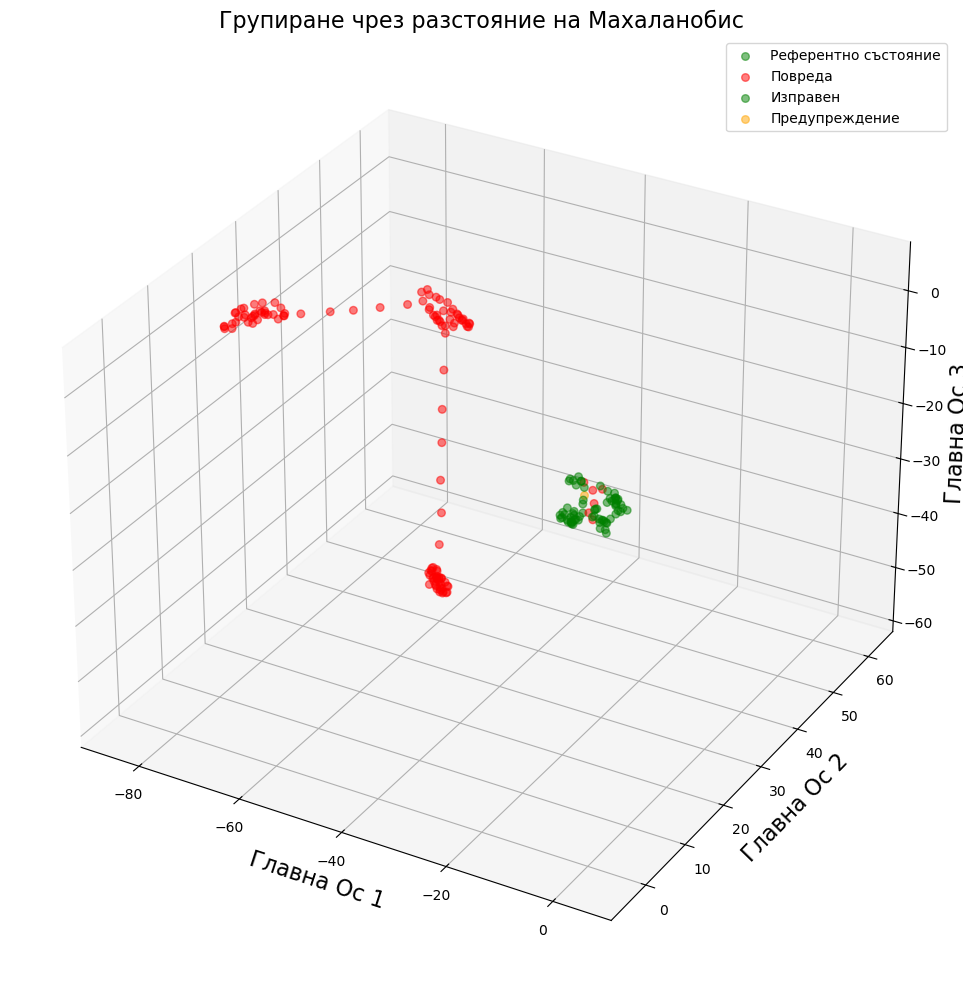

In [26]:
de_healthy = df_1797[(df_1797['fault_end'] == 0) & (df_1797['samples_per_second'] == 12000) & (df_1797['fault_element'] == 0) & (df_1797['fault_diameter'] == 0)]['DE']
de_faulty = df_1797[(df_1797['fault_end'] == 1) & (df_1797['samples_per_second'] == 12000) & (df_1797['fault_element'] == 1) & (df_1797['fault_diameter'] == 7)]['DE']

print(de_healthy.shape)
print(de_faulty.shape)

results, state_faults, scored_new = fit_mahalanobis(de_healthy, de_faulty, fs = 12000, sample_size=20)

plot_3d(results)

In [27]:
state_faults

fault     
        count  sum
State             
Error     122  116
OK         13    0
Warning     1    0

In [28]:
calc_scores(TP=116, TN = 14, FP = 6, FN = 0)

F1:  0.9747899159663865
Accuracy:  0.9558823529411765
Precision:  0.9508196721311475
Recall:  1.0


## 1797 RPM - fault_end = 1; fs = 12000; fault_element = 1;fault_diameter = 21

(243938,)
(365973,)
Thresholds (d^2): (6.251388631170325, 11.344866730144373)
State
Error    119
OK        16
Name: count, dtype: int64


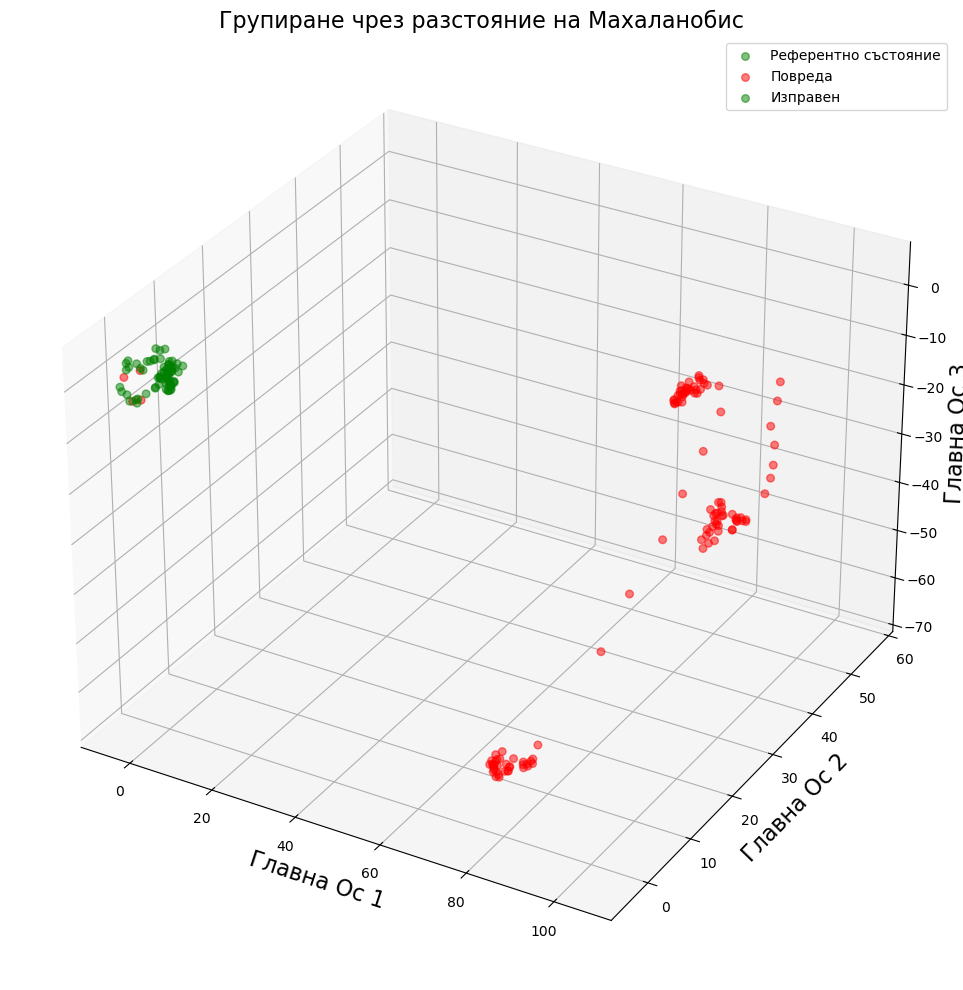

In [29]:
de_healthy = df_1797[(df_1797['fault_end'] == 0) & (df_1797['samples_per_second'] == 12000) & (df_1797['fault_element'] == 0) & (df_1797['fault_diameter'] == 0)]['DE']
de_faulty = df_1797[(df_1797['fault_end'] == 1) & (df_1797['samples_per_second'] == 12000) & (df_1797['fault_element'] == 1) & (df_1797['fault_diameter'] == 21)]['DE']

print(de_healthy.shape)
print(de_faulty.shape)

results, state_faults, scored_new = fit_mahalanobis(de_healthy, de_faulty, fs = 12000, sample_size=20)

plot_3d(results)

In [30]:
state_faults

fault     
      count  sum
State           
Error   119  115
OK       16    0

In [31]:
calc_scores(TP=115, TN=16, FP = 4, FN = 0)

F1:  0.9829059829059829
Accuracy:  0.9703703703703703
Precision:  0.9663865546218487
Recall:  1.0


# ICE

In [10]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler

def process_ice_signal(signal):
    qt = QuantileTransformer(output_distribution='normal')
    sds = StandardScaler()
    return sds.fit_transform(qt.fit_transform(signal.values.reshape(-1, 1))).flatten()

df_ice = pd.read_csv(r"D:\Repositories\PhD\parsed_data\ICE_data\internal_combustion_engine_bearings_fixed_duplicates.csv")
df_ice

,Time,Demand 1,Control 1,Output Drive 1,Channel 1,Channel 2,Channel 3,Channel 4,Channel 1 Kurtosis,Channel 2 Kurtosis,...,Rear Input 5,Rear Input 6,Rear Input 7,Rear Input 8,FAULT,RPM,HUMIDITY%,TEMPERATURE_Celsius,resultant_vibration_magnitude,resultant_vibration_magnitude_normal_dist
0,0.001450,0.125011,0.176033,0.000000,0.211458,0.209182,0.145823,1.624200e-15,2.52457,2.94874,...,0,0,0,0,1,1000,0,-10,0.331264,-1.104839
1,0.006283,0.125011,0.176033,0.000012,0.206329,0.206513,0.150478,1.643320e-15,2.32290,2.46553,...,0,0,0,0,1,1000,0,-10,0.328425,-1.113447
2,0.009633,0.125011,0.172626,0.000013,0.206351,0.194663,0.148313,1.528270e-15,2.26458,2.55488,...,0,0,0,0,1,1000,0,-10,0.320111,-1.139087
3,0.013200,0.125011,0.172626,0.000014,0.214463,0.214489,0.155652,1.791370e-15,2.53380,2.66379,...,0,0,0,0,1,1000,0,-10,0.340921,-1.076103
4,0.016583,0.125011,0.172626,0.000015,0.210449,0.198857,0.154162,1.594310e-15,2.51443,2.81510,...,0,0,0,0,1,1000,0,-10,0.328023,-1.114673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390057,27.302300,0.500044,0.515140,0.043543,0.554265,0.560519,1.633510,1.712510e-15,3.10602,3.09644,...,0,0,0,0,0,2000,50,45,1.813766,0.595405
390058,27.305700,0.500044,0.515140,0.043541,0.554672,0.560996,1.646360,1.711110e-15,3.10423,3.09293,...,0,0,0,0,0,2000,50,45,1.825617,0.601918
390059,27.309200,0.500044,0.515140,0.043536,0.555249,0.561109,1.645410,1.710140e-15,3.11372,3.09118,...,0,0,0,0,0,2000,50,45,1.824971,0.601564
390060,27.312500,0.500044,0.515305,0.043532,0.555029,0.560672,1.640060,1.711640e-15,3.11269,3.09097,...,0,0,0,0,0,2000,50,45,1.819947,0.598807


## RPM = 1000; Humidity = 50%, Temperature = 30

(5264,)
(4535,)
(5264,)
(4535,)
(5264,)
(4535,)
(121, 116)
Thresholds (d^2): (6.251388631170325, 11.344866730144373)
State
OK         84
Error      11
Warning    11
Name: count, dtype: int64


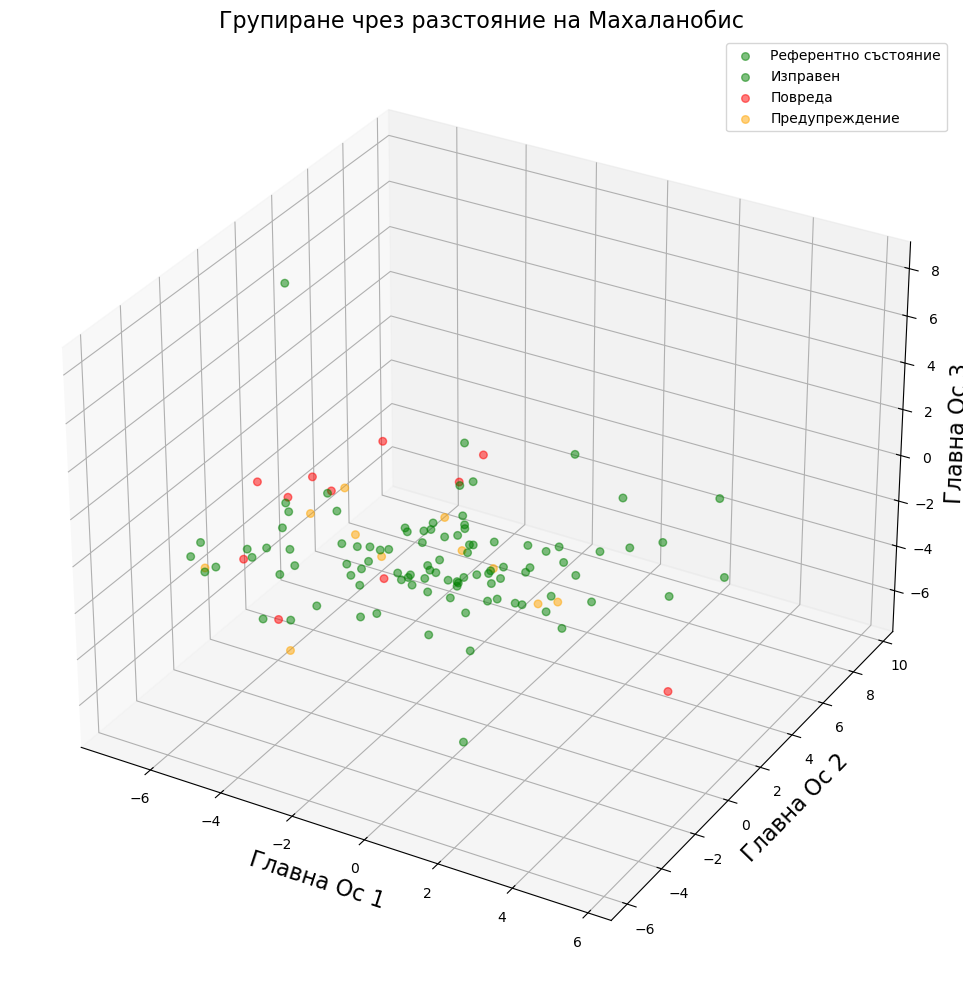

In [33]:
c1_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 1000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 1'])
c1_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 1000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 1'])
c2_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 1000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 2'])
c2_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 1000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 2'])
c3_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 1000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 3'])
c3_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 1000) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 3'])

print(c1_healthy.shape)
print(c1_faulty.shape)

print(c2_healthy.shape)
print(c2_faulty.shape)

print(c3_healthy.shape)
print(c3_faulty.shape)

results, state_faults, _ = fit_mahalanobis_ice((c1_healthy, c2_healthy, c3_healthy), (c1_faulty, c2_faulty, c3_faulty),
                                            fs = 3200, sample_size=50)

plot_3d(results)

In [34]:
state_faults

fault    
        count sum
State            
Error      11   6
OK         84  47
Warning    11   3

In [35]:
calc_scores(TP = 6, TN = 45, FP = 5, FN = 50)

F1:  0.1791044776119403
Accuracy:  0.4811320754716981
Precision:  0.5454545454545454
Recall:  0.10714285714285714


## RPM = 1500; Humidity = 50%, Temperature = 30

(1513,)
(1778,)
(1513,)
(1778,)
(1513,)
(1778,)
(40, 116)
Thresholds (d^2): (6.251388631170325, 11.344866730144373)
State
OK         26
Warning     4
Error       2
Name: count, dtype: int64


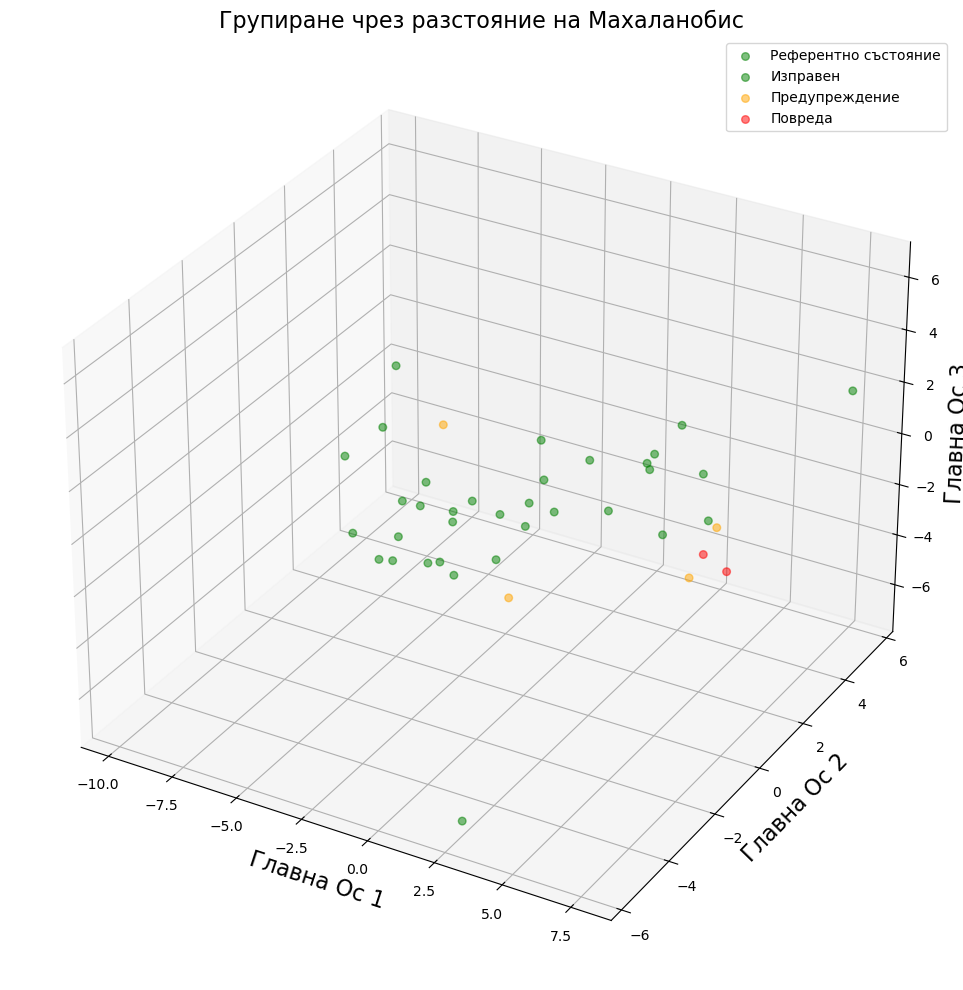

In [38]:
c1_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 1500) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 1'])
c1_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 1500) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 1'])
c2_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 1500) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 2'])
c2_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 1500) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 2'])
c3_healthy = process_ice_signal(df_ice[(df_ice['RPM'] == 1500) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 0)]['Channel 3'])
c3_faulty = process_ice_signal(df_ice[(df_ice['RPM'] == 1500) & (df_ice['HUMIDITY%'] == 50) & (df_ice['TEMPERATURE_Celsius']==30) & (df_ice['FAULT'] == 1)]['Channel 3'])

print(c1_healthy.shape)
print(c1_faulty.shape)

print(c2_healthy.shape)
print(c2_faulty.shape)

print(c3_healthy.shape)
print(c3_faulty.shape)

results, state_faults, _ = fit_mahalanobis_ice((c1_healthy, c2_healthy, c3_healthy), (c1_faulty, c2_faulty, c3_faulty),
                                            fs = 3200, sample_size=10)

plot_3d(results)

In [39]:
state_faults

fault    
        count sum
State            
Error       2   2
OK         26  18
Warning     4   2

In [40]:
calc_scores(TP=2, TN = 10, FP = 0, FN = 20)

F1:  0.16666666666666669
Accuracy:  0.375
Precision:  1.0
Recall:  0.09090909090909091


## RPM = 2000; Humidity = 50%, Temperature = 30